In [1]:
import itertools
import numpy as np
import pandas as pd 
from tqdm import tqdm 
#from collections import deque
import matplotlib.pyplot as plt 
from rdkit import Chem

#from pymatgen.core import Lattice, Structure, Molecule
#from pymatgen.analysis.graphs import MoleculeGraph

from bondnet.utils import int_atom, xyz2mol
from bondnet.core.molwrapper import rdkit_mol_to_wrapper_mol, create_wrapper_mol_from_atoms_and_bonds
#from bondnet.dataset.mg_barrier import process_species_rdkit
from bondnet.core.reaction import Reaction 
#from bondnet.core.reaction_collection import ReactionCollection

path_mg_data = "../dataset/mg_dataset/"
path_json = path_mg_data + "20220613_reaction_data.json"
path_json_v2 = path_mg_data + "20220826_mpreact_reactions.json"
mg_df = pd.read_json(path_json)
mg_df_new = pd.read_json(path_json_v2)

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.17 0.38 0.45 0.00 0.00
0.13 0.27 0.16 0.20 0.25


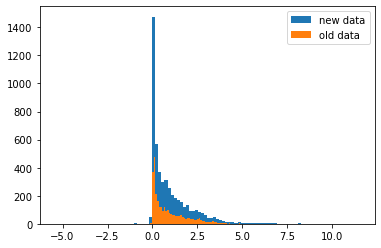

In [4]:
fig = plt.figure()
plt.hist(mg_df_new['dE_barrier'].tolist(), bins = 100, label='new data')
plt.hist(mg_df['dE_barrier'].tolist(), bins = 100, label='old data')
plt.legend()
bin_1, bin_2, bin_3, bin_4, bin_5, bin_6 = 0, 0, 0, 0, 0, 0
bin_1_new, bin_2_new, bin_3_new, bin_4_new, bin_5_new, bin_6_new = 0, 0, 0, 0, 0, 0

for value in mg_df['dE_barrier'].tolist():
    if(value <= 0.1): bin_1 += 1
    elif(value < 0.7  and value > 0.1): bin_2 += 1
    else: bin_3 += 1

for value in mg_df_new['dE_barrier'].tolist():
    if(value <= 0.04): bin_1_new += 1
    elif(value < 0.3  and value > 0.04): bin_2_new += 1
    elif(value < 0.7  and value > 0.3): bin_3_new += 1
    elif(value < 1.5  and value > 0.7): bin_4_new += 1
    else: bin_5_new += 1

old_len = len(mg_df['dE_barrier'].tolist())
new_len = len(mg_df_new['dE_barrier'].tolist())
print("{:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(bin_1/old_len, bin_2/old_len, bin_3/old_len, bin_4/old_len, bin_5/old_len))
print("{:.2f} {:.2f} {:.2f} {:.2f} {:.2f}".format(bin_1_new/new_len, bin_2_new/new_len, bin_3_new/new_len, bin_4_new/new_len, bin_5_new/new_len))


In [87]:
#mg_df[mg_df['reactant_id'] == 62707]
#print(len(mg_df.iloc[0]['product_molecule_graph']['graphs']['nodes']))
#print(mg_df.iloc[0]['product_molecule_graph']['graphs']['adjacency'])
bonds_net = []
for ind, i in enumerate(mg_df.iloc[0]['product_molecule_graph']['graphs']['adjacency']):
    for j in i: 
        bonds_net.append([ind, j['id']]) 
        
print(bonds_net)
print(mg_df.iloc[0]['product_bonds'])

[[0, 1], [1, 2], [1, 4], [2, 7], [2, 3], [2, 8], [3, 9], [3, 4], [3, 5], [4, 11], [4, 10], [5, 6]]
[[0, 1], [1, 2], [1, 4], [2, 7], [2, 3], [2, 8], [3, 9], [3, 4], [3, 5], [4, 11], [4, 10], [5, 6]]


In [3]:
bond_count = 0
for ind, row in mg_df.iterrows():
    if(len(row['bonds_broken']) == 1):bond_count+=1
    #elif(len(row['bonds_broken_nometal']) == 1):bond_count+=1
    #elif(len(row['bonds_formed_nometal'])!=1 ):bond_count+=1
    elif(len(row['bonds_formed'])!= 1):bond_count+=1
    else:bond_count+=0
print(bond_count / ind)
print(mg_df.shape)

0.772
(3001, 60)


74908_C5Cl2H10N1O2


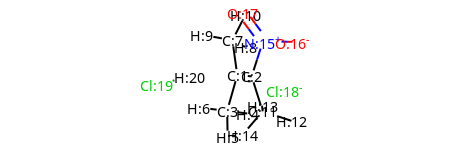

In [5]:


row = mg_df.iloc[1]
barrier = row["dE_barrier"]
species = [i['name'] for i in row['product_molecule_graph']["molecule"]["sites"]]
coords = [i["xyz"] for i in row['product_molecule_graph']["molecule"]["sites"]]
bonds = row['product_bonds']

charge = row['charge']
free_energy = row['product_free_energy']
id = str(row["reactant_id"])

product = create_wrapper_mol_from_atoms_and_bonds(
    species, coords, bonds, charge=0, free_energy=free_energy, identifier=id,
)


species = [i['name'] for i in row['reactant_molecule_graph']["molecule"]["sites"]]
coords = [i["xyz"] for i in row['reactant_molecule_graph']["molecule"]["sites"]]
bonds = row['reactant_bonds']
charge = row['charge']

free_energy = row['reactant_free_energy']
id = str(row["product_id"])
reactant = create_wrapper_mol_from_atoms_and_bonds(
    species, coords, bonds, charge=0, free_energy=free_energy, identifier=id,
)

id = [i for i in row["reaction_id"].split("-")]
id = int(id[0] + id[1] + id[2])
broken_bond = row['bonds_formed']
if(broken_bond == []):broken_bond=None
rxn = Reaction(
            reactants = [reactant], 
            products=[product], 
            free_energy= barrier,
            broken_bond = broken_bond,
            identifier = id
            )

reactant_bond_list = list(reactant.bonds.keys())
product_bond_list = list(product.bonds.keys())
reactant_bond_list.sort()
product_bond_list.sort()


#print(rxn)
#extractor = ReactionCollection([rxn])
#extractor.create_regression_dataset_reaction_network_simple(
#    struct_file=path_mg_data + "mg_struct_bond_rgrn.sdf",
#    label_file=path_mg_data + "mg_label_bond_rgrn.yaml",
#    feature_file=path_mg_data + "mg_feature_bond_rgrn.yaml"
#)
type(reactant.mol_graph)

pymatgen.analysis.graphs.MoleculeGraph

In [13]:

for ind, row in mg_df.head(10).iterrows():
  bonds = row['reactant_bonds']
  species_reactant = [int_atom(i['name']) for i in row['reactant_molecule_graph']["molecule"]["sites"]]
  coords_reactant = [i["xyz"] for i in row['reactant_molecule_graph']["molecule"]["sites"]]
  charge = row['charge']
  id = str(row["reactant_id"])
  free_energy = row['product_free_energy']
  barrier = row["dE_barrier"]
  id = str(row["reactant_id"])

  # xyz mol / rdkit
  reactant_mol = xyz2mol(atoms = species_reactant, 
      coordinates = coords_reactant, 
      charge = charge,
      )
  reactant_wrapper = rdkit_mol_to_wrapper_mol(reactant_mol[0],
      charge = charge,
      free_energy=free_energy, 
      identifier = id
      )
  reactant_graph_method = create_wrapper_mol_from_atoms_and_bonds(
      species_reactant, coords_reactant, bonds, charge=0, free_energy=free_energy, identifier=id,
  )
  if(len(reactant_wrapper.bonds) != len(reactant_graph_method.bonds)):
    reactant_graph_method.rdkit_mol = reactant_wrapper.rdkit_mol

    
  print(len(reactant_wrapper.bonds))
  print(len(reactant_graph_method.bonds))

10
10
11
11
17
17
8
8
8
8
19
20
3
6
7
7
5
6
12
12


: 

In [16]:
#reactant_structure, reactant_molecule_graph, reactant_bonds, 
#product_structure, product_molecule_graph, product_bonds, 
#transition_state_structure, 
#bonds_broken, bonds_broken_nometal, bonds_formed, bonds_formed_nometal


element_dict = {"H": 1, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, 
"F": 9, 'Ca': 20, 'Na': 11, 'Cl': 17, 'P':15, 'Mg': 12 }
preserve = 0
for i in tqdm(range(2000)):
    row = mg_df.iloc[i]
    """g_prod = nx.Graph(row["product_bonds"])
    g_react = nx.Graph(row["reactant_bonds"])
    g_prod_2 = nx.Graph(row["product_bonds_nometal"])
    g_react_2 = nx.Graph(row["reactant_bonds_nometal"])
    if(nx_graph_atom_mapping(g_prod, g_react) == None):
        if(nx_graph_atom_mapping(g_prod_2, g_react_2) == None):
            pass
        else: works_count += 1 
    else: works_count += 1"""
    species_reactant = [int_atom(i['name']) for i in row['reactant_molecule_graph']["molecule"]["sites"]]
    species_products = [int_atom(i['name']) for i in row['product_molecule_graph']["molecule"]["sites"]]
    trans_list_temp = list(i['name'] for i in list(row["transition_state_structure"]['sites']))
    trans_list = [element_dict[i] for i in trans_list_temp]
    
    if(species_products == trans_list): preserve += 1
    #if(list_xyz == coords_reactant): preserve += 1

print(preserve)



100%|██████████| 2000/2000 [00:00<00:00, 9615.40it/s]

2000


In [7]:
from rdkit import Chem
mol = Chem.MolFromSmiles("CCC")
mol.GetAtomWithIdx(1).GetAtomicNum()

6

In [4]:
from rdkit import Chem 
from bondnet.data.utils import get_dataset_species
from bondnet.data.utils import get_dataset_species_from_json
path_mg_data = "/home/santiagovargas/Documents/Dataset/mg_dataset/"
path_json = path_mg_data + "20220613_reaction_data.json"

species = get_dataset_species_from_json(path_json)

In [42]:
class BondAsNodeFeaturizerFull(BondFeaturizer):
    """
    Featurize all bonds in a molecule.

    The bond indices will be preserved, i.e. feature i corresponds to atom i.
    The number of features will be equal to the number of bonds in the molecule,
    so this is suitable for the case where we represent bond as graph nodes.

    See Also:
        BondAsEdgeBidirectedFeaturizer
    """

    def __init__(
        self,
        length_featurizer=None,
        length_featurizer_args=None,
        dative=False,
        dtype="float32",
    ):
        super(BondAsNodeFeaturizerFull, self).__init__(
            length_featurizer, length_featurizer_args, dtype
        )
        self.dative = dative


Index(['_id', 'builder_meta', 'charge', 'spin_multiplicity', 'natoms',
       'elements', 'nelements', 'composition', 'formula_alphabetical',
       'chemsys', 'symmetry', 'reaction_id', 'reactant_id', 'product_id',
       'transition_state_id', 'deprecated', 'reactant_structure',
       'reactant_molecule_graph', 'reactant_molecule_graph_nometal',
       'reactant_bonds', 'reactant_bonds_nometal', 'reactant_energy',
       'reactant_zpe', 'reactant_enthalpy', 'reactant_entropy',
       'reactant_free_energy', 'product_structure', 'product_molecule_graph',
       'product_molecule_graph_nometal', 'product_bonds',
       'product_bonds_nometal', 'product_energy', 'product_zpe',
       'product_enthalpy', 'product_entropy', 'product_free_energy',
       'transition_state_structure', 'transition_state_energy',
       'transition_state_zpe', 'transition_state_enthalpy',
       'transition_state_entropy', 'transition_state_free_energy', 'dE', 'dH',
       'dS', 'dG', 'dE_barrier', 'dH_barri

In [22]:
import torch 
from bondnet.data.utils import * 
def call(mol):
        """
        Parameters
        ----------
        mol : pandas series with 'bond', 'pymatgen'/'site'/'molecule', and 
        'composition' columns

        Returns
        -------
            Dictionary for bond features
        """
        feats, bond_list_only_metal,no_metal_binary = [], [], []
        num_atoms = 0 
        allowed_ring_size = [3, 4, 5, 6, 7]

        columns = mol.keys()
        charge = int(mol['charge'])

        if 'reactant_bonds' in columns: 
            key = 'reactant'
            #struct_key = "reactant_structure"
            #bond_key = "reactant_bonds"
            #bond_key_no_metal = "reactant_bonds_nometal"
            #graph_key = "reactant_molecule_graph"
        else: 
            key = 'product'

        
        atoms = [int_atom(atom['name']) for atom in mol[key + "_structure"]["sites"]]
        xyz_coordinates = [i["xyz"] for i in mol[key + "_structure"]["sites"]]
        bond_list = mol[key + "_bonds"]    
        bond_list_no_metal = mol[key + "_bonds_nometal"]

        atom_types = list(mol['composition'].keys()) # need to process this beforehand for products 
        for atom in atom_types: 
            num_atoms += int(mol['composition'][atom])
        species_sites = mol[key + "_molecule_graph"]['molecule']['sites']

        for i in bond_list:
            if(i not in bond_list_no_metal): 
                bond_list_only_metal.append(i)
                no_metal_binary.append(0)
            else: no_metal_binary.append(1)

        #species_len = len(species_sites)
        #species_order = [i['name'] for i in species_len]
        
        # partitions bonds into metal, no metal, and only metals
        # need to add back -- check how to count number of features a priori
        #if num_bonds == 0:
        #    ft = [0.0 for _ in range(num_feats)]
        #    if self.length_featurizer:
        #        ft += [0.0 for _ in range(len(self.length_featurizer.feature_name))]
        #    feats = [ft]
        #else:

        cycles = find_rings(num_atoms, bond_list_no_metal, allowed_ring_size, edges = True)
        rdkit_mol = xyz2mol(atoms = atoms, 
                coordinates = xyz_coordinates, 
                charge = charge,
                )
        ring_dict = ring_features_for_bonds_full(bond_list, no_metal_binary, cycles, allowed_ring_size)  
        rdkit_dict = rdkit_bond_desc(rdkit_mol[0])
        ring_dict_keys = list(ring_dict.keys())
        rdkit_dict_keys = list(rdkit_dict.keys())
        for ind, bond in enumerate(bond_list):
            ft = []
            if(tuple(bond) in ring_dict_keys):
                ft.append(ring_dict[tuple(bond)][0])
                ft.append(ring_dict[tuple(bond)][1])
                ft += ring_dict[tuple(bond)][2]

            if(tuple(bond) in rdkit_dict_keys):
                ft += rdkit_dict[tuple(bond)] 

            feats.append(ft)

        #feats = torch.tensor(feats, dtype=getattr(torch, self.dtype))
        #_feature_size = feats.shape[1]
        #_feature_name = (
        #    ["in_ring", "conjugated"]
        #    + ["ring size"] * 5
        #    + ["single", "double", "triple", "aromatic"]
        #)
   
        return {"feat": feats}

for i in range(100):
    call(mg_df.iloc[i])

filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering
filtering


In [45]:
feats = []
num_atoms = 0 
allowed_ring_size = [3, 4, 6, 7]
mol_row = mg_df.iloc[117]
columns = mol_row.keys()
from bondnet.data.utils import *

atoms = [int_atom(atom['name']) for atom in mol_row['reactant_structure']["sites"]]
xyz_coordinates = [i["xyz"] for i in mol_row['reactant_structure']["sites"]]
charge = int(mol_row['charge'])
mol = xyz2mol(atoms = atoms, 
                coordinates = xyz_coordinates, 
                charge = charge,
                )


if 'reactant_bonds' in columns: 
    bond_key = "reactant_bonds"
    bond_key_no_metal = "reactant_bonds_nometal"
    graph_key = "reactant_molecule_graph"
else: 
    bond_key = "product_bonds"
    bond_key_no_metal = "reactant_bonds_nometal"
    graph_key = "product_molecule_graph"

atom_types = list(mol_row['composition'].keys())   

for atom in atom_types: 
    num_atoms += int(mol_row['composition'][atom])
species_len = mol_row[graph_key]['molecule']['sites']
species_sites = mol_row[graph_key]['molecule']['sites']
species_order = [i['name'] for i in species_len]

bond_list = mol_row[bond_key]    
bond_list_no_metal = mol_row[bond_key_no_metal]
bond_list_only_metal,no_metal_binary = [], []

cycles = find_rings(num_atoms, bond_list_no_metal, allowed_ring_size, edges = True)



In [46]:
cycles = find_rings(num_atoms, bond_list_no_metal, allowed_ring_size, edges = True)
ring_features_for_bonds_full(bond_list, no_metal_binary, cycles, allowed_ring_size)

IndexError: list index out of range